# Task 2

In [ ]:
# # > Uncomment and run this cell if running on Google Colab
# # install required dependencies for google colab
# !git clone https://github.com/benihime91/midas-summer-internship-2021.git
# !pip install --upgrade -r "/content/midas-summer-internship-2021/requirements.txt"

In [1]:
# # > for Goggle Colab
# import sys
# sys.path.append("midas-summer-internship-2021/")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

In [4]:
# imports
import gc
import math
import os
import random
from collections import OrderedDict
import time
from typing import *

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import pytorch_lightning.metrics.functional as FM
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from fastcore.all import *
from IPython.display import Markdown, display
from PIL import Image
from pytorch_lightning.callbacks import (BackboneFinetuning, BaseFinetuning,
                                         EarlyStopping, ModelCheckpoint)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim
from torchmetrics import Accuracy
from torchvision.datasets import MNIST

# custom imports
from model import xResModel
from progress import NotebookProgressCallback
from utils import DatasetFromPandas, ToFloat, folder2df, plot_images

pl.seed_everything(42)

pd.set_option("display.max_colwidth", None)

Global seed set to 42


## Part - 2
> Next, select only 0-9 training images from the above dataset, and use the pretrained network to train on MNIST dataset. Use the standard MNIST train and test splits (http://yann.lecun.com/exdb/mnist/). How does this pretrained network perform in comparison to a randomly initialized network in terms of convergence time, final accuracy and other possible training quality metrics? Do a thorough analysis. Please save your model checkpoints.

### Getting the Data

In [3]:
import os
os.makedirs("data", exist_ok=True)

# Download the 1st Dataset using :
!wget -P "data/" https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip --qq "data/trainPart1.zip" -d "data/"

--2021-04-10 07:40:00--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-10 07:40:00--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6e973d65454ecff2975656f579.dl.dropboxusercontent.com/cd/0/inline/BMVyyWkyBSfoYyOrd-pObjx-TB8skMrk1gzOVhRxRSZ8xvXC9e2CZ0rFPW14avJIUbfeg0PC3PG1HTUh038HvEcDFQgZy2XlXA4V-7K3vcs9u3onJaiC3gBzR-Oz9KHxE5dtY7WjIC1_3BZlfgMjTsqi/file# [following]
--2021-04-10 07:40:00--  https://uc6e973d65454ecff2975656f579.dl.dropboxusercontent.com/cd/0/inline/BMVyyWkyBSfoYyOrd-pObjx-TB8skMrk1gzOVhRxRSZ8xvXC9e2CZ0rFPW14avJIUbfeg0PC3PG1HTUh038H

Perform some one-off data manipulations to get all the files and filenames in an easy to use format

In [5]:
# we do need all the Images from the given dataset in the task
# we need only 0-9 images, and we will exclude the rest
exclude = "Sample0{}"
exclude = [exclude.format(o) for o in range(11, 63)]

DATASET_PATH = Path("data/train/")

# create the dataframe containing the dataset
df = folder2df(DATASET_PATH, exclude=exclude, shuffle=True)

# encode the labels in the dataframe
unq_cls = df.target.unique()
encoder = LabelEncoder()
encoder.fit(unq_cls)

def encode_label(x):
    "Encoder `x`, given x is a scalar value"
    return encoder.transform([x]).item()

df["cat_label"] = df["target"].map(encode_label)
df.head()

,image_id,target,cat_label
0,data/train/Sample005/img005-042.png,Sample005,4
1,data/train/Sample004/img004-030.png,Sample004,3
2,data/train/Sample002/img002-055.png,Sample002,1
3,data/train/Sample005/img005-047.png,Sample005,4
4,data/train/Sample003/img003-010.png,Sample003,2


The code cell below specifies the transformations that I will be using the preprocess the Images. First of all I as done in the previous notebook I will presize the Images to 80x80 pix and CenterCrop to 64x64 pix. `ToFloat` transformation normalizes the Images and brings the values of the pixels from `(0, 255)` to `(0, 1)` range.

In [6]:
# specify transformations
PRESIZE  = 80
IMG_SIZE = 64

transforms = T.Compose([
    T.Resize((PRESIZE, PRESIZE)),
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    ToFloat(max_value=255.0),
])

Let's get our data into `Dataset` and `DataLoader` s. `DatasetFromPandas` creates a `torch.utils.data.Dataset` instance from a `pandas DataFrame` using `transforms`.

In [7]:
ds = DatasetFromPandas(df, transforms)

dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True,)

print("Number of Images in the given dataset :", len(ds))

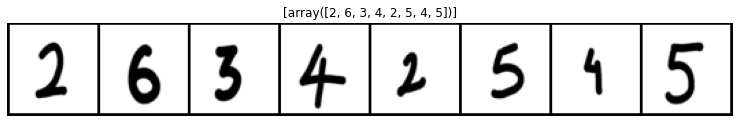

In [8]:
plot_images(dl)

### Getting the MNIST dataset 

I will directly load the standart MNIST dataset from `torchvision`. `Torchvision` splits the data into training and test set in the say way it is done in the standard MNIST dataset.

In [9]:
# standard MNIST train dataset
mnist_train = MNIST(root="data/", train=True, download=True, transform=transforms)

# standard MNIST test dataset
mnist_test  = MNIST(root="data/", train=False, download=True, transform=transforms) 

# create dataloaders
mnist_train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


Information on the dataset -

In [91]:
print("Number of Images in the MNIST train dataset :", len(mnist_train))
print("Number of Images in the MNIST test  dataset :", len(mnist_test))

Number of Images in the MNIST train dataset : 60000
Number of Images in the MNIST test  dataset : 10000


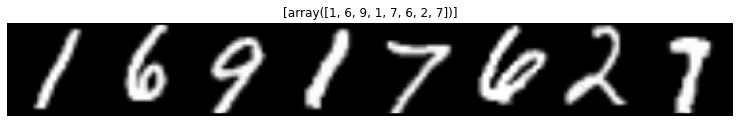

In [10]:
# view images from the training dataloader -
plot_images(mnist_train_dl)

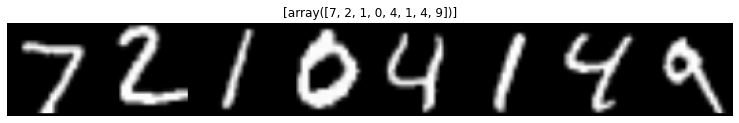

In [11]:
# view images from the training dataloader -
plot_images(mnist_test_dl)

### Create the PyTorch Lightning Task

For training I will be using PyTorch Lightning ⚡️. PyTorch Lightning expects the whole training pipeline to be defined under a LightningModule. Let's convert our model in a LightningModule.

For evaluating the model initially I will use the `Accuracy` metric and for loss function i will use the standard `nn.CrossEntropyLoss()` from PyTorch.

The code block below create a general PyTorch Lightning Classification Task which helps us iterate different models inside a `LightningModule`.

In [12]:
class ClassificationTask(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float, wd: float = 1e-02):
        super().__init__()
        self.save_hyperparameters("lr", "wd")
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
            
    def freeze_backbone(self):
        for param in model.backbone.parameters():
            param.requires_grad = False
        
    def forward(self, xb):
        "Same as nn.Module forward"
        return self.model(xb)

    def shared_step(self, batch, batch_idx, *args, **kwargs):
        """
        The common step shared between the training, validation & test steps
        """
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        acc  = FM.accuracy(F.softmax(y_hat), y)
        metrics = {'accuracy': acc, 'loss': loss}
        return metrics
    
    def training_step(self, batch, batch_idx, *args, **kwargs):
        metrics = self.shared_step(batch, batch_idx, *args, **kwargs)
        metrics = {'train_acc': metrics['accuracy'], 'train_loss': metrics['loss']}
        self.log_dict(metrics)
        return metrics["train_loss"]

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        metrics = self.shared_step(batch, batch_idx, *args, **kwargs)
        metrics = {'val_acc': metrics['accuracy'], 'val_loss': metrics['loss']}
        self.log_dict(metrics)

    def test_step(self, batch, batch_idx, *args, **kwargs):
        metrics = self.shared_step(batch, batch_idx, *args, **kwargs)
        metrics = {'test_acc': metrics['accuracy'], 'test_loss': metrics['loss']}
        self.log_dict(metrics)
           
    def configure_optimizers(self):
        """
        define optimizers and LR schedulers for use in training.
        """
        
        parameters = list(self.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        
        # Set up Optimizer
        opt = optim.AdamW(trainable_parameters, 
                          lr=self.hparams.lr, 
                          weight_decay=self.hparams.wd, 
                          betas=(0.9, 0.99), eps=1e-05)
        
        
        # Set up 1 CosineAnnealing Scheduler
        steps = len(self.train_dataloader())
        epochs= self.trainer.max_epochs
        
        scheduler= optim.lr_scheduler.CosineAnnealingLR(opt, T_max=int(steps * epochs))
        
        return [opt], [dict(scheduler=scheduler, interval='step')]

For training I will be using `AdamW` optimizer and schedule the learning rate using `CosineAnnealingLR`. `CosineAnnealingLR` sets the learning rate of each parameter group using a cosine annealing schedule. From my personal experiments I have found that this scheduler gives very good results so I used this .

### Training

> In this Task we are take the pretrained model and finetune it on the MNIST dataset.

Let's grab the pretrained model checkpoint -

In [13]:
cbs = [NotebookProgressCallback(), ModelCheckpoint(os.getcwd(), filename="stage-01")]

model = xResModel(num_outputs=10)
    
task = ClassificationTask(model, lr=3e-02)

# unfreeze and train all the paramters
task.unfreeze()
trainer = pl.Trainer(callbacks=cbs, max_epochs=10, gpus=1, precision=16)

trainer.fit(task, train_dataloader=dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.017     Total estimated model params size (MB)


epoch,train_acc,train_loss,time,samples/s
0,0.375000,2.290404,9.825500,1.323100
1,0.187500,2.334851,5.921400,2.195400
2,0.125000,1.787718,5.891100,2.206700
3,0.687500,1.238700,5.919100,2.196300
4,0.625000,1.119080,5.853100,2.221000
5,0.687500,0.937782,5.843600,2.224700
6,0.875000,0.674889,5.820600,2.233500
7,0.937500,0.376230,5.826000,2.231400
8,0.875000,0.391283,5.855000,2.220300
9,1.000000,0.107854,5.825100,2.231700


1

This section we will define our finetune logic using the pytorch lightning `BaseFinetuning` Callback. I main logic is that for a few epochs I will be training only the classifier part of the Model and then,

In [14]:
class FinetuningCallback(BaseFinetuning):
    def __init__(self, unfreeze_at_epoch=8):
        self._unfreeze_at_epoch = unfreeze_at_epoch
        # while finetuning we do not want to train the batchnorm layers
        self.train_bn = False 

    def freeze_before_training(self, pl_module):
        # freeze any module you want
        # Here, we are freezing ``backbone``
        # pl_module.print("Freezing the Backbone of the Model")
        self.freeze(modules=pl_module.model.backbone, train_bn=self.train_bn)

    def finetune_function(self, pl_module, current_epoch, optimizer, optimizer_idx):
        # When `current_epoch` is `unfreeze_at_epoch`, backbone will start training.
        if current_epoch == self._unfreeze_at_epoch:
            # pl_module.print("UnFreezing the Backbone of the Model")
            self.unfreeze_and_add_param_group(
                modules=pl_module.model.backbone,
                optimizer=optimizer,
                train_bn=self.train_bn,
            )

In [17]:
cbs = [
    NotebookProgressCallback(), 
    # we train only the classifier of the model for 5 epochs, after which we train the whole model
    FinetuningCallback(unfreeze_at_epoch=5), 
    EarlyStopping(monitor="val_acc", patience=2),
    ModelCheckpoint(os.getcwd(), filename="mnist-finetuned", monitor="val_acc")
    ]

# Initialize the Model
model = xResModel(num_outputs=10)

# load the classification task from the trained checkpoint
finetuned_task = ClassificationTask.load_from_checkpoint("stage-01.ckpt", model=model, lr=3e-03)

trainer = pl.Trainer(callbacks=cbs, max_epochs=12, gpus=1, precision=16, num_sanity_val_steps=0)

# Start Finetuning the Model
trainer.fit(finetuned_task, train_dataloader=mnist_train_dl, val_dataloaders=mnist_test_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
2.6 K     Trainable params
1.3 M     Non-trainable params
1.3 M     Total params
5.017     Total estimated model params size (MB)


epoch,train_acc,train_loss,val_acc,val_loss,time,samples/s
0,0.750000,0.945039,0.788300,0.772400,30.960700,35.367400
1,0.656250,0.964086,0.815500,0.662114,30.805800,35.545300
2,0.687500,0.779321,0.833000,0.606848,31.024700,35.294500
3,0.718750,0.792623,0.838500,0.581183,31.632900,34.615900
4,0.750000,0.630380,0.839500,0.573176,31.834600,34.396600
5,0.968750,0.051686,0.971800,0.094406,43.748300,25.029500
6,0.968750,0.084026,0.982000,0.056424,42.199100,25.948400
7,0.937500,0.154627,0.985600,0.045663,42.544900,25.737500
8,0.968750,0.095195,0.987200,0.042952,42.345100,25.859000
9,1.000000,0.004300,0.986500,0.041228,42.509600,25.758900


1

In [19]:
cbs = [
    NotebookProgressCallback(), 
    EarlyStopping(monitor="val_acc"), 
    ModelCheckpoint(os.getcwd(), filename="mnist-scratch", monitor="val_acc")
    ]

# Initialize the Model
model_scratch = xResModel(num_outputs=10)

# Initialize the Task from random initialization
task_scratch = ClassificationTask(model_scratch, lr=3e-03)

# Unfreeze and train the whole model from scratch
task_scratch.unfreeze()

trainer = pl.Trainer(callbacks=cbs, max_epochs=12, gpus=1, precision=16, num_sanity_val_steps=0)

# Start Training the Model from random initialization
trainer.fit(task_scratch, train_dataloader=mnist_train_dl, val_dataloaders=mnist_test_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.017     Total estimated model params size (MB)


epoch,train_acc,train_loss,val_acc,val_loss,time,samples/s
0,1.000000,0.019710,0.956000,0.128255,42.009100,26.065800
1,1.000000,0.008381,0.981200,0.062089,41.881900,26.145000
2,1.000000,0.001238,0.990500,0.027599,41.271400,26.531700
3,1.000000,0.005757,0.991400,0.025953,41.632900,26.301300
4,1.000000,0.000161,0.992600,0.022831,41.946800,26.104500
5,1.000000,0.000334,0.994200,0.019758,42.020700,26.058600
6,0.968750,0.030008,0.993600,0.020489,41.761800,26.220100
7,1.000000,0.000150,0.995400,0.016690,42.296200,25.888800
8,1.000000,0.002556,0.994800,0.016966,42.183300,25.958100
9,1.000000,0.002969,0.995000,0.017070,42.039500,26.046900


1

### Evaluating the Models beyond Accuracy ...

---



* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-Score


To make comparisons and evaluate our trained model, first we need to make predictions

In [46]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [47]:
classes = mnist_train.class_to_idx
classes = {x:y for y, x in classes.items()}
classes

{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

We'll be doing the same examinations of the model

First, we get the predictions for each image in the test set...

In [48]:
def get_predictions(model, iterator, device="cpu"):
    model.to(device)
    model.eval()

    images = []
    labels = []
    probs  = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs  = torch.cat(probs, dim = 0)

    return images, labels, probs

In [67]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

We can then plot the most incorrectly predicted images along with the predicted class and the actual class...

In [68]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_most_incorrect(incorrect, classes, n_images = 10, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label.data.cpu().numpy().item()]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label.data.cpu().numpy().item()]
        incorrect_class = classes[incorrect_label.data.cpu().numpy().item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

#### Evaluating the Funetuned Model -

In [102]:
model = xResModel(num_outputs=10)

finetuned_model = ClassificationTask.load_from_checkpoint("mnist-finetuned.ckpt", model=model)
finetuned_model.freeze()
finetuned_model.eval()

images, labels, probs = get_predictions(finetuned_model, mnist_test_dl, device="cuda:0")
pred_labels = torch.argmax(probs, 1)

In [103]:
print(classification_report(labels.data.cpu().numpy(), pred_labels.data.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



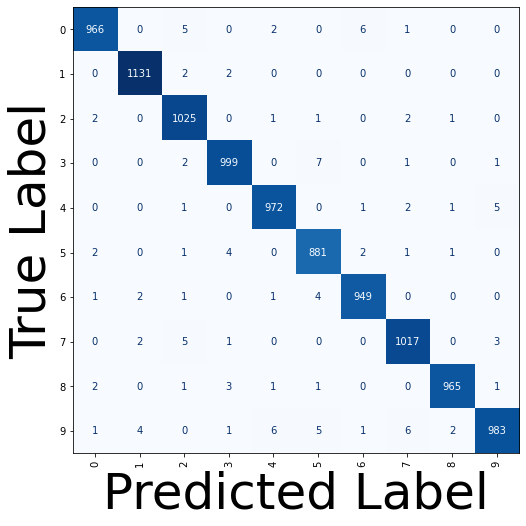

In [104]:
plot_confusion_matrix(labels, pred_labels, classes)

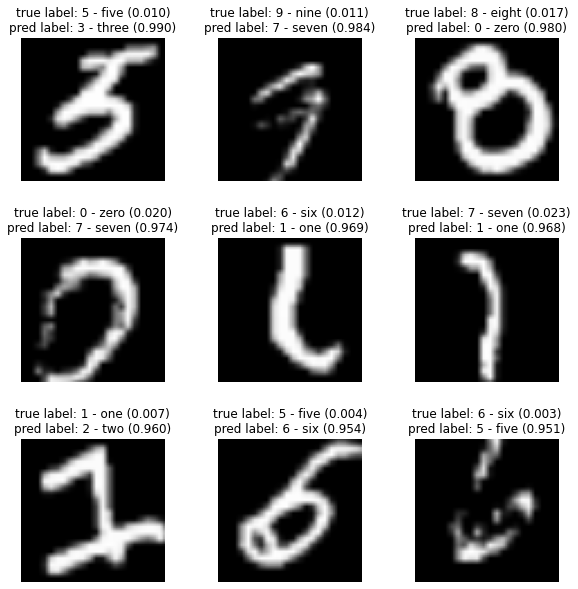

In [105]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

N_IMAGES = 15

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

#### Evaluting the model trained from scratch - 

In [98]:
model = xResModel(num_outputs=10)

scratch_model = ClassificationTask.load_from_checkpoint("mnist-scratch.ckpt", model=model)
scratch_model.freeze()
scratch_model.eval()

images, labels, probs = get_predictions(scratch_model, mnist_test_dl, device="cuda:0")
pred_labels = torch.argmax(probs, 1)

In [99]:
print(classification_report(labels.data.cpu().numpy(), pred_labels.data.cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       0.99      1.00      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



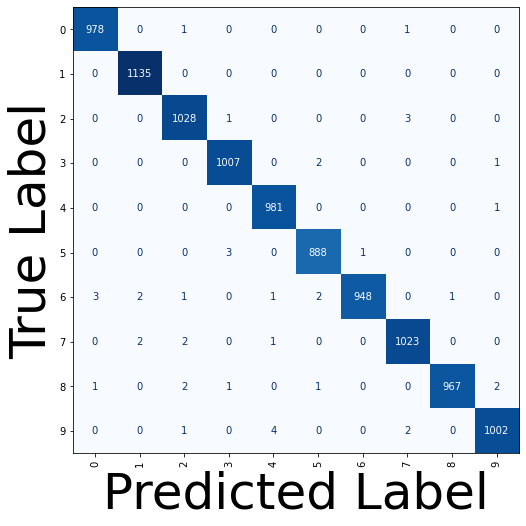

In [100]:
plot_confusion_matrix(labels, pred_labels, classes)

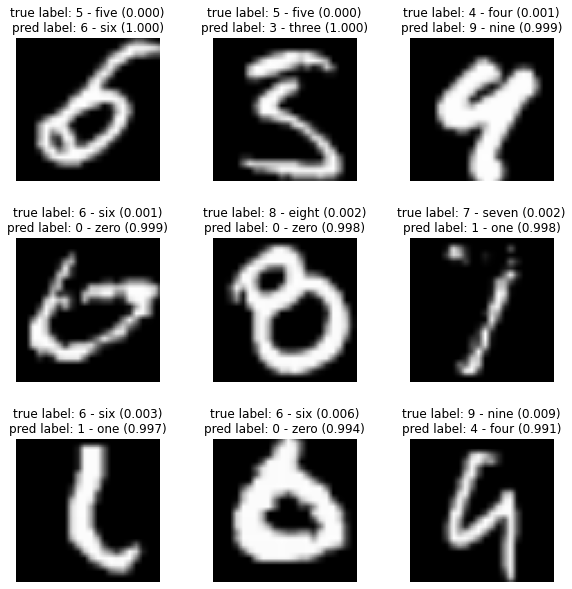

In [101]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

N_IMAGES = 15

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

## Part - 3
> Finally, take the following dataset (https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip), train on this dataset and provide test accuracy on the MNIST test set, using the same test split from part 2. Train using scratch random initialization and using the pretrained network part 1. Do the same analysis as 2 and report what happens this time. Try and do qualitative analysis of what's different in this dataset. Please save your model checkpoints.


In [84]:
import os
os.makedirs("data/part-3", exist_ok=True)

# Download the Dataset using :
!wget -P "data/" https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip
!unzip --qq "data/mnistTask3.zip" -d "data/part-3"

--2021-04-10 08:28:29--  https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/otc12z2w7f7xm8z/mnistTask3.zip [following]
--2021-04-10 08:28:30--  https://www.dropbox.com/s/raw/otc12z2w7f7xm8z/mnistTask3.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd986c77d8a90b3257ba330d609.dl.dropboxusercontent.com/cd/0/inline/BMUX8ir16UQBUwRFKIbXCLPrwtdUAJEPXb8mHbhFbd9DOFmrwHGWFHqxGpitE5JCrYEVTwmGv5-htovu76gSA6QARV_GRsK4n_oJMT57eMXcM3q13WpNi342a0W6Bg5TUnfPQsnoM-Kf1axZ5fXH_aKV/file# [following]
--2021-04-10 08:28:30--  https://ucd986c77d8a90b3257ba330d609.dl.dropboxusercontent.com/cd/0/inline/BMUX8ir16UQBUwRFKIbXCLPrwtdUAJEPXb8mHbhFbd9DOFmrwHGWFHqxGpitE5JCrYEVTwmGv5-htovu76gS

In [85]:
DATASET_PATH = Path("data/part-3/mnistTask/")

# create the dataframe containing the dataset
df = folder2df(DATASET_PATH, shuffle=True)

# encode the labels in the dataframe
unq_cls = df.target.unique()
encoder = LabelEncoder()
encoder.fit(unq_cls)

def encode_label(x):
    "Encoder `x`, given x is a scalar value"
    return encoder.transform([x]).item()

df["cat_label"] = df["target"].map(encode_label)
df.head()

,image_id,target,cat_label
0,data/part-3/mnistTask/3/image_049952.jpg,3,3
1,data/part-3/mnistTask/7/image_023600.jpg,7,7
2,data/part-3/mnistTask/7/image_002247.jpg,7,7
3,data/part-3/mnistTask/8/image_035267.jpg,8,8
4,data/part-3/mnistTask/8/image_004846.jpg,8,8


In [90]:
ds2 = DatasetFromPandas(df, transforms)
dl2 = torch.utils.data.DataLoader(ds2, batch_size=32, shuffle=True,)

print("Number of Images in the given dataset :", len(ds2))

Number of Images in the given dataset : 60000


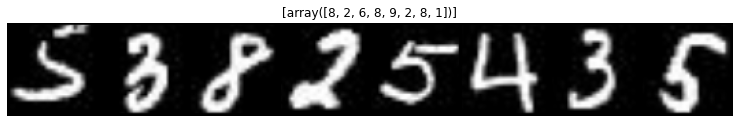

In [87]:
plot_images(dl2)

In [89]:
cbs = [
    NotebookProgressCallback(), 
    EarlyStopping(monitor="val_acc"), 
    ModelCheckpoint(os.getcwd(), filename="mnist-part3", monitor="val_acc")
    ]

# Initialize the Model
model_scratch = xResModel(num_outputs=10)

# Initialize the Task from random initialization
task_scratch = ClassificationTask(model_scratch, lr=3e-03)

# Unfreeze and train the whole model from scratch
task_scratch.unfreeze()

trainer = pl.Trainer(callbacks=cbs, max_epochs=12, gpus=1, precision=16, num_sanity_val_steps=0)

# Start Training the using the given training dataset and the MNIST test dataset
trainer.fit(task_scratch, train_dataloader=mnist_train_dl, val_dataloaders=mnist_test_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.017     Total estimated model params size (MB)


epoch,train_acc,train_loss,val_acc,val_loss,time,samples/s
0,0.968750,0.050943,0.974700,0.080224,42.666800,25.664000
1,0.968750,0.062999,0.979600,0.067230,41.897500,26.135200
2,1.000000,0.000231,0.991800,0.028650,41.786200,26.204900
3,1.000000,0.004066,0.993400,0.021438,41.730300,26.239900
4,1.000000,0.005007,0.992000,0.025284,42.236500,25.925500
5,0.968750,0.027834,0.993400,0.021073,42.130400,25.990700
6,1.000000,0.000959,0.995000,0.015380,41.971600,26.089100
7,1.000000,0.000681,0.996000,0.013317,42.579000,25.716900
8,1.000000,0.000029,0.996300,0.014564,42.024400,26.056300
9,1.000000,0.000071,0.995200,0.015543,42.062300,26.032800


1

Evaluate the model - 

In [92]:
model = xResModel(num_outputs=10)

model = ClassificationTask.load_from_checkpoint("mnist-part3.ckpt", model=model)
model.freeze()
model.eval()

images, labels, probs = get_predictions(model, mnist_test_dl, device="cuda:0")
pred_labels = torch.argmax(probs, 1)

In [93]:
print(classification_report(labels.data.cpu().numpy(), pred_labels.data.cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



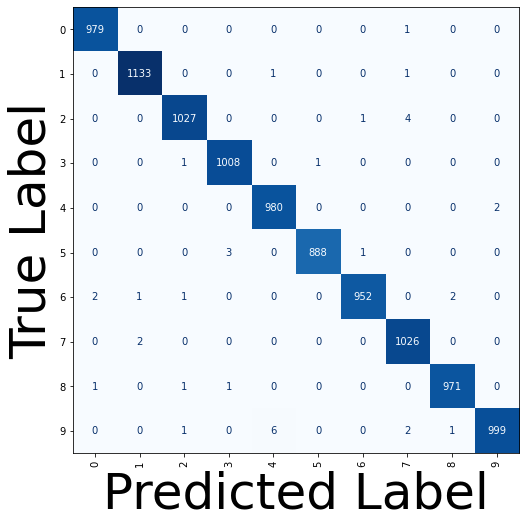

In [94]:
plot_confusion_matrix(labels, pred_labels, classes)

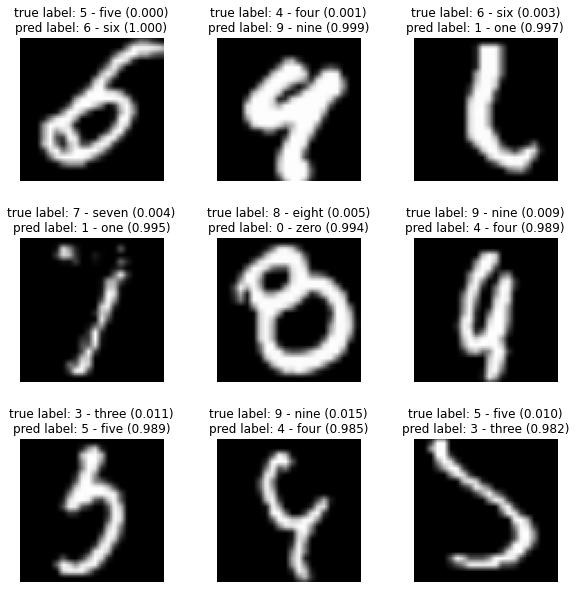

In [97]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

N_IMAGES = 15

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)